# Predicting reports of bullying, racism, and unwanted sexual behavior from app store reviews

In the [Washington Post's analysis](https://www.washingtonpost.com/technology/2019/11/22/apple-says-its-app-store-is-safe-trusted-place-we-found-reports-unwanted-sexual-behavior-six-apps-some-targeting-minors/), they designed a machine learning algorithm to detect patterns of "unsafe" behavior through analyzing App Store reviews. Using a spreadsheet of hand-tagged reviews, we'll both train an algorithm to spot these behaviors as well as learn what words tips our algorithm off. **Instead of reading all the reviews ourselves, we'll use the classifier to track down the reviews that are probably interesting for us as journalists.**

<p class="reading-options">
  <a class="btn" href="/wapo-app-reviews/predict-reviews">
    <i class="fa fa-sm fa-book"></i>
    Read online
  </a>
  <a class="btn" href="/wapo-app-reviews/notebooks/Predict reviews.ipynb">
    <i class="fa fa-sm fa-download"></i>
    Download notebook
  </a>
  <a class="btn" href="https://colab.research.google.com/github/littlecolumns/ds4j-notebooks/blob/master/wapo-app-reviews/notebooks/Predict reviews.ipynb" target="_new">
    <i class="fa fa-sm fa-laptop"></i>
    Interactive version
  </a>
</p>

### Prep work: Downloading necessary files
Before we get started, we need to download all of the data we'll be using.
* **reviews-marked.csv:** combined app reviews - US-based reviews of multiple "random chat apps" from Apple's App Store (Chat for Strangers, Holla, Skout, and Yubo)
* **reviews-marked.csv:** annotated reviews - Reviews of "random chat apps," marked for racist, bullying, or sexual behavior


In [ ]:
# Make data directory if it doesn't exist
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/wapo-app-reviews/data/reviews-marked.csv -P data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/wapo-app-reviews/data/reviews-marked.csv -P data

## Our data

Starting from the [app store reviews we scraped](/wapo-app-reviews/scrape-app-store-reviews/), we then opened up the results in Google Sheets and manually tagged reviews for the behaviors we're looking for (racism, bullying, sexual content).

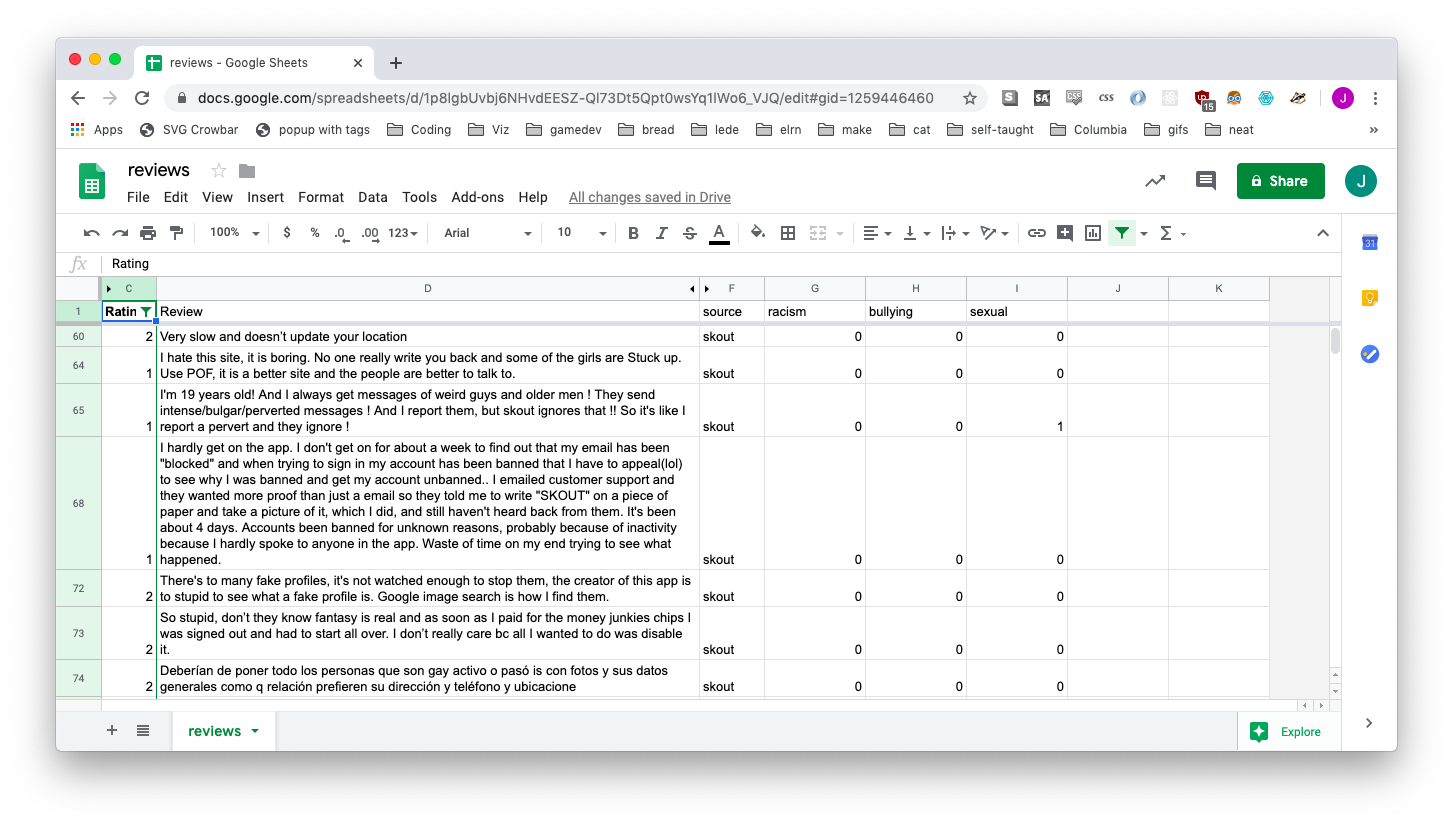

To speed things in finding negativity to classify I filtered to only show reviews that are 1 or 2 stars. Let's move on to reading this dataset into pandas.

In [53]:
import pandas as pd
pd.set_option("display.max_colwidth", 300)

# Read in our data, then drop ones without a text
# review and get rid of a few unwannted columns
df = pd.read_csv("data/reviews-marked.csv")
df = df.dropna(subset=['Review'])
df = df.drop(columns=['Country', 'Date', 'Version'])
df.shape

(56055, 6)

Overall we hve around 56k reviews. What do they look like?

In [54]:
df.head()

,Rating,Review,source,racism,bullying,sexual
0,5,It’s a great app to meet new people and chat in very satisfied with downloading this app i recommend this app if you like to chat or just to meet new people. And you can choose which country To find different users!,holla,NaN,NaN,NaN
1,5,"Holla is an excellent app, where I get to know new people every time and even get to make new friends. I truly recommend this application to all people!",holla,NaN,NaN,NaN
2,1,Get rid of micro transactions or i will find a new app to use. Why should i have to pay for that it’s so stupid,holla,0.0,0.0,0.0
3,5,"Free to use app, meet people around the world.",holla,NaN,NaN,NaN
4,5,I got this app and everything has been different. I’ve met so many interesting people. From around the world. I was recently reunited with my high school girlfriend. We’re getting married. I met and married The love of my Life thanks to Holla. Thanks Holla!!!!!,holla,NaN,NaN,NaN


We've only filled in `0` and `1` for racism, bullying and unwanted sexual behavior in a handful of reviews. We'll separate our content into two pieces - known reviews that we've labeled, and unknown reviews that we have not labeled. We'll use the known ones to train our classifier, and then run it on unknown to find possible reviews to examine.

In [55]:
known = df[df.sexual.notna()].copy()
unknown = df[df.sexual.isna()].copy()

We're using `.copy()` in case we add new columns - if we don't do this we'll get yelled at by pandas, because pandas won't know whether to save the new column in `known` also to `df`. How many did we label?

In [56]:
known.shape

(330, 6)

In [57]:
known.head()

,Rating,Review,source,racism,bullying,sexual
2,1,Get rid of micro transactions or i will find a new app to use. Why should i have to pay for that it’s so stupid,holla,0.0,0.0,0.0
6,1,This is good but most of my messages never show up. This is very crapy and needs to be fixed,skout,0.0,0.0,0.0
8,1,I was really enjoying this app. This brought me out of the box. I’m an extremely shy person and this gave me somewhere to talk to nice people. I just got kicked of bc I’m 16 not “18” and I think that this change it kind of stupid bc yeah it’s for protection but like someone else said all you hav...,holla,0.0,0.0,0.0
13,1,It won’t lemme go live or anything like I think you fixed it for everyone but me and now it says I’m banned for no reason I didn’t even do anything,holla,0.0,0.0,0.0
15,1,No real ppl all fake or no reply,skout,0.0,0.0,0.0


That's not *nearly* enough, but ok! Let's move on.

## Vectorize our text

We'll be using a stemmed TF-IDF vectorizer to both combine similar words - "pic" and "pics" - as well as have uncommon words carry a little more weight.

In [58]:
#!pip install pystemmer
#!pip install sklearn

In [59]:
%%time

from sklearn.feature_extraction.text import TfidfVectorizer
import Stemmer

# English stemmer from pyStemmer
stemmer = Stemmer.Stemmer('en')

analyzer = TfidfVectorizer().build_analyzer()

# Override CountVectorizer
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: stemmer.stemWords(analyzer(doc))

# Create a new StemmedCountVectorizer
vectorizer = StemmedTfidfVectorizer()
matrix = vectorizer.fit_transform(known.Review)

# Build a dataframe of words, purely out of curiosity
words_df = pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names())
words_df.head(5)

CPU times: user 43.8 ms, sys: 4.81 ms, total: 48.6 ms
Wall time: 49.6 ms


,000,10,100,13,14,15,16,17,18,19,...,للدردشة,للرمنسية,للعب,مخصص,مكان,من,نطاق,والصداقة,وضع,ومكان
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.116557,0.0,0.106118,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We have 1,324 different words we're looking at, but only around 350 reviews. **You should never have more features than data points.** We're going to do it anyway, though, and see if things work out.

In the spirit of doing things right, we'll tweak out vectorizer a little bit - we only want to see words that show up in fewer than 30% of reviews, and we'll take a maximum of 500 features.

In [83]:
vectorizer = StemmedTfidfVectorizer(max_features=500, max_df=0.30)
matrix = vectorizer.fit_transform(known.Review)

# Build a dataframe of words, purely out of curiosity
words_df = pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names())
words_df.head(5)

,10,100,18,24,30,50,abl,about,accept,account,...,wouldn,write,wrong,yeah,year,yet,you,your,yubo,zero
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.127443,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.13998,0.0,0.0,0.172011,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.125648,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0


What's the split between "normal" reviews and ones featuring unwanted sexual behavior?

In [84]:
known.sexual.value_counts()

0.0    314
1.0     16
Name: sexual, dtype: int64

Notice we've run into another problem, which is **very imbalanced data here**. Can a classifier accurately figure out what a sexual comment looks like if it's only seen sixteen of them?

## Train a classifier

While we could use most any kind of classifier, the LinearSVC classifier is a good one for text analysis. To deal with the class imbalance issue, we could [do it the more complex/correct way](/classification/correcting-for-imbalanced-datasets/) or we could just suggest the classifer balance out the classes when learning by using `class_weight='balanced'`.

In [85]:
%%time

from sklearn.svm import LinearSVC

X = matrix
y = known.sexual

clf = LinearSVC(class_weight='balanced')
clf.fit(X, y)

CPU times: user 4.92 ms, sys: 2.89 ms, total: 7.81 ms
Wall time: 6.1 ms


LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

It would be nice to train our classifier, but I'm going to be honest: with only sixteen rows labeled as sexual content it isn't going to do us much good. We *know* we aren't doing this in the best possible way, but we're hoping we can find it helpful regardless.

## Use our classifier

When we vectorized our reviews before, we used `vectorizer.fit_transform`. This taught the vectorizer all of the words in the reviews *and* transformed them into numbers the algorithm could understand.

This time we just use `.transform`, to convert our text into numbers. We don't need `.fit` because **we don't need the vectorizer to learn any new words.** Any word our classifier hasn't seen before won't be helpful because our classifier won't know whether it unwanted implies sexual behavior or not.

In [86]:
X = vectorizer.transform(unknown.Review)

unknown['predicted'] = clf.predict(X)
unknown['predicted_proba'] = clf.decision_function(X)
# If you use a different classifier, you might use .predict_proba instead
# unknown['predicted_proba'] = clf.predict_proba(X)[:, 1]

How many did our classifier predict as related to sexual content?

In [87]:
unknown.predicted.value_counts()

0.0    55187
1.0      538
Name: predicted, dtype: int64

While there are over 500 that have been predicted to probably be about unwanted sexual behavior, we cana ctually dig a little deeper. Let's take a look at the value for the `predicted_proba` column.

In [88]:
unknown.sort_values(by='predicted_proba', ascending=True).head(2)

,Rating,Review,source,racism,bullying,sexual,predicted,predicted_proba
24350,1,It links me to people who live nowhere near me,skout,NaN,NaN,NaN,0.0,-1.839318
24474,1,Please fix the location distance search it is not accurate. I hit nearby and it brings up people who are 70 to 100 miles away. Please fix the location is horrible,skout,NaN,NaN,NaN,0.0,-1.819893


In [89]:
unknown.sort_values(by='predicted_proba', ascending=False).head(2)

,Rating,Review,source,racism,bullying,sexual,predicted,predicted_proba
55612,4,Like a small thing that's pink/ blue to show whether your m or f. That would be nice. And to all the guys out there... Put your dick back in your pants. I'm a guy but I don't creep on girls. There a thing called porn.,chat-for-strangers,NaN,NaN,NaN,1.0,1.187417
19428,2,All the guys on here ever ask for is nudes like I don't want to send my nudes to you,skout,NaN,NaN,NaN,1.0,1.159415


Ones where `predicted_proba` is **low** are unlikely to be about unwanted sexual behavior, while ones where `predicted_proba` is **high** are likely to be about unwanted sexual behavior. The closer to `0` the value is, the more uncertain the classifier is.

> We called this column `predicted_proba` because for some classifiers it's probability, e.g. an 80% chance it's about unwanted sexual beheavior. In the spirit of cutting and pasting code it seems easier to just re-use the name and remember the difference instead of calling it `decision_function`. 

Instead of just taking reviews the classifier marked as definitely interesting to us, **we could also sort by `predicted_proba` and take the 1000**. That way we get the ones that are "definitely" about unwanted sexual behavior as well as some more borderline cases.

In [90]:
to_investigate = unknown.sort_values(by='predicted_proba', ascending=False).head(1000)
to_investigate.sample(5)

,Rating,Review,source,racism,bullying,sexual,predicted,predicted_proba
12651,4,"The app is great, but please put filters on the match thing. That is the only thing I find wrong. On the app I want to find people that I'm interested in, not everyone in the entire world.",holla,NaN,NaN,NaN,1.0,0.486977
53922,2,App crashes alot and keeps on flipping screens when i try2 find a new person on there it always goes back 2 home when i dont want it too they need 2 fix this!,chat-for-strangers,NaN,NaN,NaN,0.0,-0.077797
55918,3,It's ok but most of the guys disconnect immediately if ur not a girl which can be annoying if ur a non perverted guy and just want to chat but it's also fun to troll these guys,chat-for-strangers,NaN,NaN,NaN,1.0,0.544633
34084,2,"Very inflexible. You can switch to another app without closing the discussion you're in, which means you can ever talk with the same person again. If they send a link or a pic, you can't see it. \n\nI'm deleting now.",chat-for-strangers,NaN,NaN,NaN,0.0,-0.144568
33711,1,This app is the worst this one guy asked me to show him private things he also showed me his parts and told me to do the same and I didn’t know what to do so I... I just hope ppl don’t do anything bad on this app pls cause this app can ruin your life,holla,NaN,NaN,NaN,1.0,0.000937


While we *could* look at them in the notebook here, it's probably better to save them to a CSV and take a better look later. Let's save the top 1000 for later research.

In [91]:
to_investigate.to_csv("data/to-investigate.csv", index=False)

### Explaining our classifier

While we're at it, what's the classifier even doing? We can assume that it's looking at the words and figuring out that certain words signal unwanted sexual behavior or not, but which words do which things?

This is called **explainability**, and it's a big part of being able to argue about whether your machine learning algorithm makes sense or not. The specific question of which words are more or less important is called **feature importance**.

There's a lot of different, somewhat complicated ways to ask scikit-learn what features are important, but there's a Python library called [eli5](https://eli5.readthedocs.io/) that does an almost-perfect job making it only take one line of code.

In [92]:
import eli5

# eli5 gets our classifier and our vectorizer, so it knows what
# numbers are what words (otherwise you just get numbers and weights)
eli5.explain_weights(clf, vec=vectorizer)

Weight?,Feature
+1.837,nude
+1.656,guy
+1.320,pervert
+1.221,men
+1.193,thing
+1.088,off
+1.071,dick
+1.045,find
+0.977,on
+0.963,filter


Seems reasonable.

## Review

We have a lot of app store reviews, some of which we have **manually tagged** for certain kinds of behavior. We use those to **train** a machine learning algorithm, teaching it which words are associated with which kinds of behavior.

After we've trained the algorithm on our **known, labeled reviews** we can then send it **unknown reviews**, and it will flag those we need to review. Since we don't mind reviewing a large number of reviews, we also save a handful that the algorithm flagged as barely not-interesting.

## Discussion topics

Did we label enough reviews? Beyond the idea of "more data is better," what are the benefits of labeling more reviews?

If we need to label more reviews, would it be helpful to search for words like "nude" and "guy" to see if we can easily track down some unwanted sexual behavior? Or should we just keep going one-by-one?

We selected the top 500 features, not including any words that showed up more than 30% of the time. What if a representative word like "nude" or "pervert" showed up in half of the reviews? How could we prevent this from happening?

We didn't test our classifier because we didn't have enough labeled as sexual content to really make a meaningful test. Is that okay? Think about what we were using this for.

The Washington Post used sentences like "At least 19 percent of the reviews on ChatLive mentioned unwanted sexual approaches." What would you need to do to feel comfortable making such a numbers-based statement?

Why did we use a **stemmer?** If we had thousands of labeled reviews instead of just a few dozen, would that have been as necessary?